In [1]:
import sys
sys.path.insert(0, '/users/ankushroy/iris/src')
print(sys.path)

['/users/ankushroy/iris/src', '/users/ankushroy/iris/src/models/tokenizer', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python38.zip', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/lib-dynload', '', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages']


In [2]:
"""
Credits to https://github.com/CompVis/taming-transformers
"""

from dataclasses import dataclass
from typing import Any, Tuple


from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses


batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)

In [3]:
from typing import List

import torch
import torch.nn as nn
## Configuration files 
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [4]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],  
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 1024  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
print(encoder)
print(decoder)

Tokenizer : shape of latent is (1024, 8, 8).
Encoder(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleLis

In [5]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [6]:
# Define dataset
import torch
#import sys
#from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))

In [7]:
# develop dataset
from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 
batch_size=1

df_train = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/ankushroy/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/ankushroy/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/ankushroy/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/ankushroy/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/ankushroy/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/ankushroy/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(train_aadedwre), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size, shuffle=False, num_workers=8),
          }


30632 3493 3560


In [8]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:0
PyTorch version: 1.11.0


In [ ]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=80
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=0
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [0,2,4,9,19,29,39,49,59,79]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_8/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_8/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)


Pysteps configuration file found at: /users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages/pysteps/pystepsrc

MSE: 14.078 MAE: 0.826 PCC: 0.476 
 CSI(1mm): 0.372 CSI(2mm): 0.288 CSI(8mm): 0.167 
 ACC(1mm): 0.914 ACC(2mm): 0.932 ACC(8mm): 0.973 
 FSS(1km): 0.913 FSS(10km): 0.886 FSS(20km): 0.824 FSS(30km): 0.65


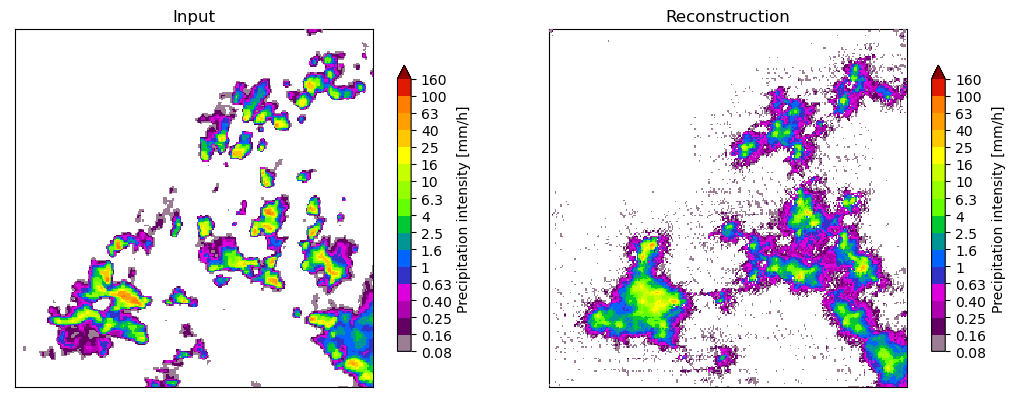

MSE: 14.084 MAE: 0.88 PCC: 0.438 
 CSI(1mm): 0.393 CSI(2mm): 0.31 CSI(8mm): 0.165 
 ACC(1mm): 0.904 ACC(2mm): 0.927 ACC(8mm): 0.971 
 FSS(1km): 0.892 FSS(10km): 0.875 FSS(20km): 0.828 FSS(30km): 0.644


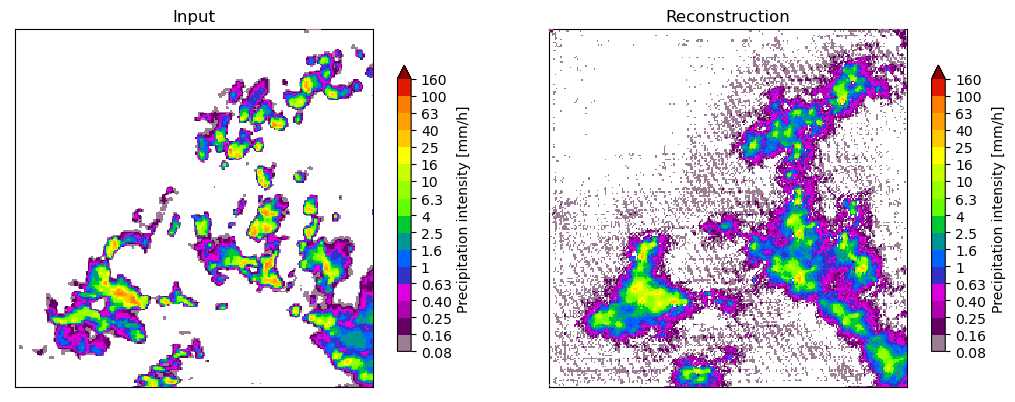

MSE: 2.86 MAE: 0.441 PCC: 0.634 
 CSI(1mm): 0.485 CSI(2mm): 0.46 CSI(8mm): 0.088 
 ACC(1mm): 0.902 ACC(2mm): 0.943 ACC(8mm): 0.988 
 FSS(1km): 0.944 FSS(10km): 0.929 FSS(20km): 0.897 FSS(30km): 0.806


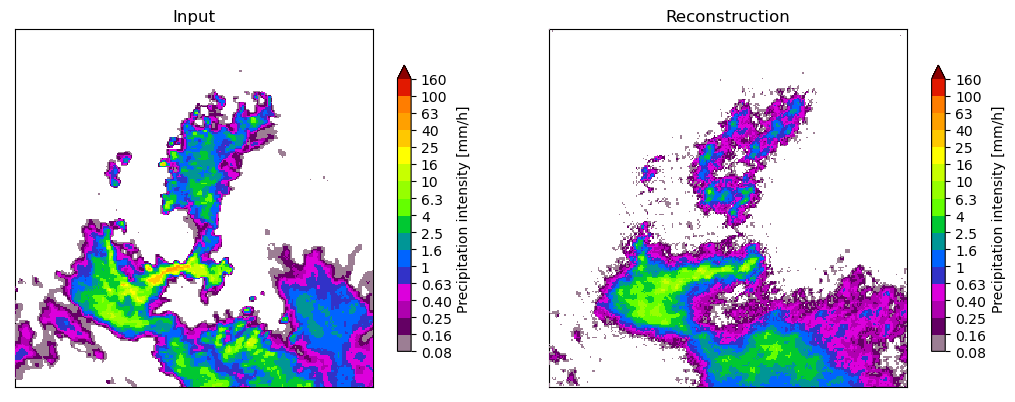

MSE: 14.599 MAE: 0.853 PCC: 0.385 
 CSI(1mm): 0.38 CSI(2mm): 0.312 CSI(8mm): 0.137 
 ACC(1mm): 0.916 ACC(2mm): 0.936 ACC(8mm): 0.97 
 FSS(1km): 0.876 FSS(10km): 0.852 FSS(20km): 0.792 FSS(30km): 0.62


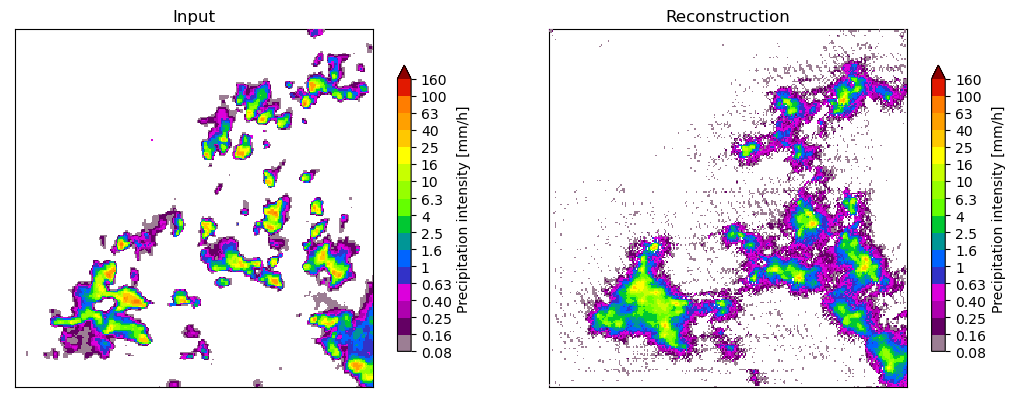

MSE: 13.963 MAE: 0.783 PCC: 0.344 
 CSI(1mm): 0.356 CSI(2mm): 0.288 CSI(8mm): 0.088 
 ACC(1mm): 0.92 ACC(2mm): 0.939 ACC(8mm): 0.973 
 FSS(1km): 0.885 FSS(10km): 0.862 FSS(20km): 0.801 FSS(30km): 0.605


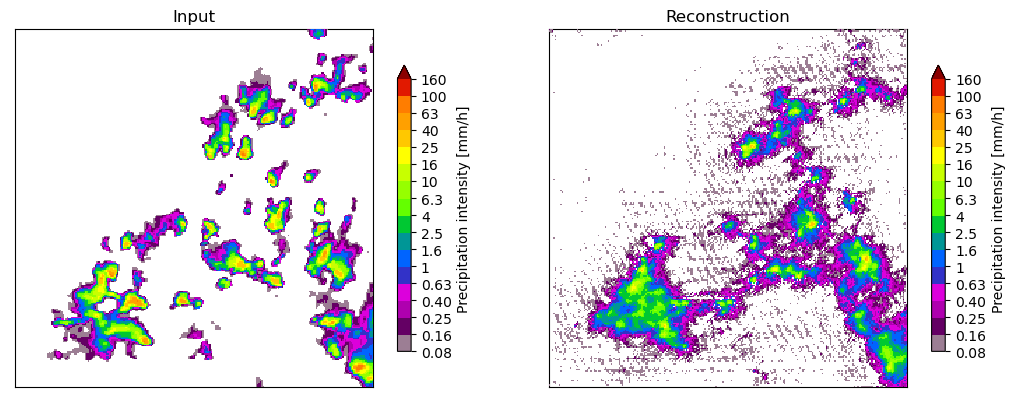

pcc_average: 0.4554


In [9]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
tokenizer.eval()
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_10/vqvae_checkpoint_epoch250', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4, :, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_r_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

Training the Model from 250th Epoch to 350th Epoch


In [ ]:
import numpy as np
from collections import defaultdict
checkpoint_path = '/space/ankushroy/Tokeniser_exp2_1024_embdim_10/vqvae_checkpoint_epoch250'
checkpoint = torch.load(checkpoint_path,map_location=device)
tokenizer.load_state_dict(checkpoint['model_state_dict'])
optimizer_tokenizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_total_step=0.0
intermediate_losses = defaultdict(float)

#device = torch.device("cuda:1")  # Specify the GPU device
tokenizer.to(device)

epoch_start=250
num_epochs=350

all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [259,269,279,289,299,309,319,329,339,349]
    
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/ankushroy/Tokeniser_exp2_1024_embdim_9/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/ankushroy/Tokeniser_exp2_1024_embdim_10/metrices.npy', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

epoch 250
Losses: Total = 0.1681
Losses: Total = 0.0719
Losses: Total = 0.0746
Losses: Total = 0.0652
Losses: Total = 0.1363
Losses: Total = 0.0437
Losses: Total = 0.1414
Losses: Total = 0.0699
Losses: Total = 0.1407
Losses: Total = 0.1474
Losses: Total = 0.1960
Losses: Total = 0.1465
Losses: Total = 0.1306
Losses: Total = 0.1455
Losses: Total = 0.1562
Losses: Total = 0.1115
Losses: Total = 0.1535
Losses: Total = 0.1664
Losses: Total = 0.0784
Losses: Total = 0.0550
Losses: Total = 0.1100
Losses: Total = 0.1768
Losses: Total = 0.0764
Losses: Total = 0.1653
Losses: Total = 0.1071
Losses: Total = 0.1064
Losses: Total = 0.1245
Losses: Total = 0.0983
Losses: Total = 0.1211
Losses: Total = 0.0495
Losses: Total = 0.1179
Losses: Total = 0.0921
Losses: Total = 0.0976
Losses: Total = 0.1739
Losses: Total = 0.1008
Losses: Total = 0.0578
Losses: Total = 0.0355
Losses: Total = 0.1048
Losses: Total = 0.0500
Losses: Total = 0.0998
Losses: Total = 0.0957
Losses: Total = 0.0474
Losses: Total = 0.0885
L

Losses: Total = 0.1086
Losses: Total = 0.1207
Losses: Total = 0.1305
Losses: Total = 0.0738
Losses: Total = 0.1291
Losses: Total = 0.0924
Losses: Total = 0.0781
Losses: Total = 0.0665
Losses: Total = 0.1372
Losses: Total = 0.1390
Losses: Total = 0.0505
Losses: Total = 0.1083
Losses: Total = 0.0898
Losses: Total = 0.0824
Losses: Total = 0.0711
Losses: Total = 0.1001
Losses: Total = 0.0696
Losses: Total = 0.0237
Losses: Total = 0.0066
Losses: Total = 0.1608
Losses: Total = 0.1795
Losses: Total = 0.1009
Losses: Total = 0.0179
Losses: Total = 0.0376
Losses: Total = 0.0683
Losses: Total = 0.0681
Losses: Total = 0.0876
Losses: Total = 0.0939
Losses: Total = 0.1322
Losses: Total = 0.0447
Losses: Total = 0.0335
Losses: Total = 0.1015
Losses: Total = 0.1684
Losses: Total = 0.0854
Losses: Total = 0.0642
Losses: Total = 0.1463
Losses: Total = 0.1922
Losses: Total = 0.0228
Losses: Total = 0.1738
Losses: Total = 0.1204
Losses: Total = 0.1351
Losses: Total = 0.0933
Losses: Total = 0.0766
Losses: Tot

Losses: Total = 0.0773
Losses: Total = 0.0453
Losses: Total = 0.1115
Losses: Total = 0.1550
Losses: Total = 0.1049
Losses: Total = 0.1793
Losses: Total = 0.1189
Losses: Total = 0.0727
Losses: Total = 0.0958
Losses: Total = 0.1425
Losses: Total = 0.1466
Losses: Total = 0.1349
Losses: Total = 0.0189
Losses: Total = 0.0930
Losses: Total = 0.0241
Losses: Total = 0.0400
Losses: Total = 0.0998
Losses: Total = 0.0207
Losses: Total = 0.1036
Losses: Total = 0.0344
Losses: Total = 0.0370
Losses: Total = 0.0279
Losses: Total = 0.1326
Losses: Total = 0.1003
Losses: Total = 0.1153
Losses: Total = 0.1306
Losses: Total = 0.0879
Losses: Total = 0.1027
Losses: Total = 0.0617
Losses: Total = 0.0665
Losses: Total = 0.0667
Losses: Total = 0.1602
Losses: Total = 0.1405
Losses: Total = 0.0716
Losses: Total = 0.0439
Losses: Total = 0.1059
Losses: Total = 0.0328
Losses: Total = 0.1961
Losses: Total = 0.0285
Losses: Total = 0.1031
Losses: Total = 0.0569
Losses: Total = 0.1185
Losses: Total = 0.0434
Losses: Tot

Losses: Total = 0.0664
Losses: Total = 0.1206
Losses: Total = 0.1159
Losses: Total = 0.0376
Losses: Total = 0.0534
Losses: Total = 0.1381
Losses: Total = 0.1121
Losses: Total = 0.0860
Losses: Total = 0.0571
Losses: Total = 0.1105
Losses: Total = 0.1085
Losses: Total = 0.0827
Losses: Total = 0.1190
Losses: Total = 0.1094
Losses: Total = 0.0109
Losses: Total = 0.0925
Losses: Total = 0.1578
Losses: Total = 0.0700
Losses: Total = 0.0963
Losses: Total = 0.0406
Losses: Total = 0.1007
Losses: Total = 0.1613
Losses: Total = 0.1154
Losses: Total = 0.0944
Losses: Total = 0.0724
Losses: Total = 0.1411
Losses: Total = 0.0982
Losses: Total = 0.0902
Losses: Total = 0.0667
Losses: Total = 0.1062
Losses: Total = 0.1119
Losses: Total = 0.0696
Losses: Total = 0.1253
Losses: Total = 0.2054
Losses: Total = 0.1329
Losses: Total = 0.0922
Losses: Total = 0.0843
Losses: Total = 0.0222
Losses: Total = 0.1675
Losses: Total = 0.1513
Losses: Total = 0.1360
Losses: Total = 0.1630
Losses: Total = 0.0877
Losses: Tot

Losses: Total = 0.0704
Losses: Total = 0.1144
Losses: Total = 0.1799
Losses: Total = 0.0195
Losses: Total = 0.0925
Losses: Total = 0.0664
Losses: Total = 0.0756
Losses: Total = 0.0313
Losses: Total = 0.0928
Losses: Total = 0.0136
Losses: Total = 0.1149
Epoch 252: Total Loss = 46.6316
epoch 253
Losses: Total = 0.0549
Losses: Total = 0.1682
Losses: Total = 0.0324
Losses: Total = 0.0926
Losses: Total = 0.0674
Losses: Total = 0.0652
Losses: Total = 0.1597
Losses: Total = 0.0814
Losses: Total = 0.0654
Losses: Total = 0.1281
Losses: Total = 0.0699
Losses: Total = 0.1041
Losses: Total = 0.1247
Losses: Total = 0.1110
Losses: Total = 0.1603
Losses: Total = 0.1260
Losses: Total = 0.1773
Losses: Total = 0.0401
Losses: Total = 0.1275
Losses: Total = 0.0618
Losses: Total = 0.0679
Losses: Total = 0.0568
Losses: Total = 0.0207
Losses: Total = 0.0811
Losses: Total = 0.1236
Losses: Total = 0.0077
Losses: Total = 0.0370
Losses: Total = 0.1627
Losses: Total = 0.0870
Losses: Total = 0.2031
Losses: Total =